In [17]:
filepath = "S1-4PPdm.wfn"

include("./wfn.jl");
include("./ext21.jl");
#TODO: Use precompilation

In [18]:
#Struct containing all relevant WFN information
f = read_wfn(filepath, device = gpu);
f.mol_name

"S1_4PP_DMF"

In [19]:
#Points to evaluate
r⃗ = [0 0 0;
     0.1 0 0.7;
     0 0 -0.7;
     0 1 0;
    1 -1 0;
    0.4 0.5 0.5;
    1 1 1;
    0 0 0.6;
    0 0 0.5] .|> Float32 |> gpu

9×3 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0   0.0   0.0
 0.1   0.0   0.7
 0.0   0.0  -0.7
 0.0   1.0   0.0
 1.0  -1.0   0.0
 0.4   0.5   0.5
 1.0   1.0   1.0
 0.0   0.0   0.6
 0.0   0.0   0.5

In [20]:
#Code for calculating the critical points of ρ via Broyden's method.
# Work in progress

    #Assignation of center per nuclei position.
    r⃗_μ = f.center_assignments .|> (a -> f.nuclei_pos[a,:]) |> (x -> hcat(x...)) |> transpose |> gpu
    #@tullio Δr⃗_μ[p,dim] := r⃗[r,dim] - r⃗_μ[p,dim] grad=false
    #Difference between each proposed point and each nuclei center assigned to a MO
    @tullio Δr⃗[p,dim,r] := r⃗[r,dim] - r⃗_μ[p,dim] grad=false
    #Squared distances
    sq_dist = dropdims(sum(Δr⃗.^2, dims=2), dims=2)
    #Gaussian constant
    @tullio c_g[p,r] := get_gaussian_constant(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    
    @tullio ∂gc∂X[p,r] := get_∂gc∂X(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    @tullio ∂gc∂Y[p,r] := get_∂gc∂Y(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    @tullio ∂gc∂Z[p,r] := get_∂gc∂Z(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false

    @tullio ∂²gc∂X²[p,r] := get_∂²gc∂X²(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    @tullio ∂²gc∂XY[p,r] := get_∂²gc∂XY(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    @tullio ∂²gc∂XZ[p,r] := get_∂²gc∂XZ(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    @tullio ∂²gc∂Y²[p,r] := get_∂²gc∂Y²(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    @tullio ∂²gc∂YZ[p,r] := get_∂²gc∂YZ(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    @tullio ∂²gc∂Z²[p,r] := get_∂²gc∂Z²(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=false
    
    F0 = exp.(-f.exponents .* sq_dist)
    toalp = -2.0 * f.exponents
    toalpe = toalp .* F0
    ∂F∂X = toalpe .* Δr⃗[:,1,:]
    ∂F∂Y = toalpe .* Δr⃗[:,2,:]
    ∂F∂Z = toalpe .* Δr⃗[:,3,:]
    ∂²F∂X² = (toalp .* Δr⃗[:,1,:] .* ∂F∂X) + toalpe
    ∂²F∂XY = toalp .* Δr⃗[:,2,:] .* ∂F∂X
    ∂²F∂XZ = toalp .* Δr⃗[:,3,:] .* ∂F∂X
    ∂²F∂Y² = (toalp .* Δr⃗[:,2,:] .* ∂F∂Y) + toalpe
    ∂²F∂YZ = toalp .* Δr⃗[:,3,:] .* ∂F∂Y
    ∂²F∂Z² = (toalp .* Δr⃗[:,3,:] .* ∂F∂Z) + toalpe
    
    Ψ_μ = c_g .* F0
    ∂Ψ_μ∂X = ∂gc∂X .* F0 + c_g .* ∂F∂X
    ∂Ψ_μ∂Y = ∂gc∂Y .* F0 + c_g .* ∂F∂Y
    ∂Ψ_μ∂Z = ∂gc∂Z .* F0 + c_g .* ∂F∂Z
    ∂²Ψ_μ∂X² = (∂²gc∂X² .* F0) + (2 * ∂gc∂X .* ∂F∂X) + (c_g .* ∂²F∂X²)
    ∂²Ψ_μ∂XY = (∂²gc∂XY .* F0) + (∂gc∂X .* ∂F∂Y) + (∂gc∂Y .* ∂F∂X) + (c_g .* ∂²F∂XY)
    ∂²Ψ_μ∂XZ = (∂²gc∂XZ .* F0) + (∂gc∂X .* ∂F∂Z) + (∂gc∂Z .* ∂F∂X) + (c_g .* ∂²F∂XZ)
    ∂²Ψ_μ∂Y² = (∂²gc∂Y² .* F0) + (2 * ∂gc∂Y .* ∂F∂Y) + (c_g .* ∂²F∂Y²)
    ∂²Ψ_μ∂YZ = (∂²gc∂YZ .* F0) + (∂gc∂Y .* ∂F∂Z) + (∂gc∂Z .* ∂F∂Y) + (c_g .* ∂²F∂YZ)
    ∂²Ψ_μ∂Z² = (∂²gc∂Z² .* F0) + (2 * ∂gc∂Z .* ∂F∂Z) + (c_g .* ∂²F∂Z²)

    Φ_r = f.mo * Ψ_μ
    ∂Φ∂X = f.mo * ∂Ψ_μ∂X
    ∂Φ∂Y = f.mo * ∂Ψ_μ∂Y
    ∂Φ∂Z = f.mo * ∂Ψ_μ∂Z
    ∂²Φ∂X² = f.mo * ∂²Ψ_μ∂X²
    ∂²Φ∂XY = f.mo * ∂²Ψ_μ∂XY
    ∂²Φ∂XZ = f.mo * ∂²Ψ_μ∂XZ
    ∂²Φ∂Y² = f.mo * ∂²Ψ_μ∂Y²
    ∂²Φ∂YZ = f.mo * ∂²Ψ_μ∂YZ
    ∂²Φ∂Z² = f.mo * ∂²Ψ_μ∂Z²

    #ρ = electronic density for proposed points
    ρ = transpose(Φ_r.^2) * f.occ_no
    #Newton/pseudo-Newton methods optimize 3 equations for 3 variables:
    #Variables: X, Y, Z of each point
    #Equations: Gradient of ρ at X, Y, Z
    ∂ρ∂X = transpose(∂Φ∂X .* Φ_r) * f.occ_no
    ∂ρ∂Y = transpose(∂Φ∂Y .* Φ_r) * f.occ_no
    ∂ρ∂Z = transpose(∂Φ∂Z .* Φ_r) * f.occ_no
    #Newton/pseudo-Newton method need the inverse jacobian of the function to optimize.
    #Calculating second derivatives of ρ to obtain the Hessian
    ∂²ρ∂X² = 2 * (transpose(∂Φ∂X.^2)  + transpose(∂²Φ∂X² .* Φ_r)) * f.occ_no
    ∂²ρ∂XY = 2 * (transpose(∂Φ∂X .* ∂Φ∂Y)  + transpose(∂²Φ∂XY .* Φ_r)) * f.occ_no
    ∂²ρ∂XZ = 2 * (transpose(∂Φ∂X .* ∂Φ∂Z)  + transpose(∂²Φ∂XZ .* Φ_r)) * f.occ_no
    ∂²ρ∂Y² = 2 * (transpose(∂Φ∂Y.^2) + transpose(∂²Φ∂Y² .* Φ_r)) * f.occ_no
    ∂²ρ∂YZ = 2 * (transpose(∂Φ∂Y .* ∂Φ∂Z)  + transpose(∂²Φ∂YZ .* Φ_r)) * f.occ_no
    ∂²ρ∂Z² = 2 * (transpose(∂Φ∂Z.^2) + transpose(∂²Φ∂Z² .* Φ_r)) * f.occ_no

    #Generating the inverse of the Hessian of ρ by determinants/cofactors
    @tullio Y[m,n,p] := generate_Y_matrix_el(m, n, ∂²ρ∂X²[p],∂²ρ∂XY[p],∂²ρ∂XZ[p],∂²ρ∂Y²[p],∂²ρ∂YZ[p],∂²ρ∂Z²[p]) (m in 1:3, n in 1:3) grad=false
    @tullio inv_H[m,n,p] := Y[m,n,p] / (∂²ρ∂X²[p]*Y[1,1,p] + ∂²ρ∂XY[p]*Y[2,1,p] + ∂²ρ∂XZ[p]*Y[3,1,p]) grad=false

3×3×9 CuArray{Float64, 3, CUDA.Mem.DeviceBuffer}:
[:, :, 1] =
 -1.2361e-5   -6.80357e-7   1.6595e-5
 -6.80357e-7  -1.79717e-5  -1.9833e-6
  1.6595e-5   -1.9833e-6    3.0323e-5

[:, :, 2] =
 -1.10877     -0.00369952    0.172117
 -0.00369952  -1.13429      -0.000881142
  0.172117    -0.000881142   0.310996

[:, :, 3] =
 -2.06127     0.0066432  -0.0377155
  0.0066432  -0.846602    0.0030245
 -0.0377155   0.0030245   0.189523

[:, :, 4] =
 -8.42151   -0.198424    1.01222
 -0.198424   8.46014     0.320672
  1.01222    0.320672  -10.251

[:, :, 5] =
   9.19597    -0.0943644  -11.8348
  -0.0943644   2.89239     -6.15305
 -11.8348     -6.15305      8.4929

[:, :, 6] =
 -9.78719  -3.65      10.9573
 -3.65     -3.38633    7.15205
 10.9573    7.15205  -12.9999

[:, :, 7] =
 -0.458963   8.44019  -4.68555
  8.44019   -4.85247   1.80099
 -4.68555    1.80099  14.9156

[:, :, 8] =
 -0.478892      0.000141206   0.00473609
  0.000141206  -0.474072     -0.000650624
  0.00473609   -0.000650624   0.0878161

In [23]:
#Calculate ρ for the n points in r⃗
get_electronic_density(r⃗, f, gpu)

9-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 97.45674
  0.34709018
  0.3184764
  0.16741587
  0.120431334
  0.2512611
  0.06921032
  0.41182414
  0.59918463

In [24]:
#Loss function for gradient descent. Not recommended.
get_sum_squared_gradients(r⃗, f, gpu)

345108.93779310817

In [ ]:
#Unstable and outdated method using gradient descent. Do not execute
p, ρ = find_points(r⃗, f, iters=100, η = 0.05, device = gpu)

# Experimentation below, execution not recommended

In [62]:
ρ

9-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.2637181
 0.41073042
 0.41073042
 0.06222068
 0.028996903
 0.09001044
 0.018786743
 0.41073042
 0.27265108

In [5]:
f.nuclei_pos

2×3 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0   0.69742
 0.0  0.0  -0.69742

In [3]:
#r⃗ = [0.1 0.4 -0.2] |> Float32
r⃗ = [0 0 0;
     0 0 0;
     0 0 0;
     0 0 0] .|> Float32 |> gpu

r⃗_μ = f.center_assignments .|> (a -> f.nuclei_pos[a,:]) |> (x -> hcat(x...)) |> transpose |> gpu

n_points  = size(r⃗)[1]

4

In [4]:
r⃗

4×3 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [5]:
using CUDA, CUDAKernels, KernelAbstractions
using Tullio
using BenchmarkTools
CUDA.allowscalar(false)

aaa = gpu(f.type_assignments)

@tullio Δr⃗[p,dim,r] := r⃗[r,dim] - r⃗_μ[p,dim];
@tullio c_g[p,r] := get_gaussian_constant(aaa[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r])

765×4 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0           1.0
   0.0068786     0.0068786     0.0068786     0.0068786
   0.0068786     0.0068786     0.0068786     0.0068786
   0.0068786     0.0068786     0.0068786     0.0068786
  -0.00082203   -0.00082203   -0.00082203   -0.00082203
   ⋮                                       
 -10.9709      -10.9709      -10.9709      -10.9709
   0.159599      0.159599      0.159599      0.159599
  -3.63041      -3.63041      -3.63041      -3.63041
   1.0           1.0           1.0           1.0
   1.0           1.0           1.0  

In [7]:
#norms = sum((r⃗ .- r⃗_μ).^2, dims=2) .|> sqrt #version for r⃗ consising of 1 3-D point
#version for r⃗ consising of n 3-D points
sq_dist = dropdims(sum(Δr⃗.^2, dims=2), dims=2) |> gpu

LoadError: UndefVarError: Δr⃗ not defined

In [42]:
function get_gaussian_constant(t::Integer, ΔX::Float32, ΔY::Float32, ΔZ::Float32)::Float32
    t == 1 ? 1.0 :
    t == 2 ? ΔX :
    t == 3 ? ΔY :
    t == 4 ? ΔZ :
    t == 5 ? ΔX^2 :
    t == 6 ? ΔY^2 :
    t == 7 ? ΔZ^2 :
    t == 8 ? ΔX*ΔY :
    t == 9 ? ΔX*ΔZ :
    t == 10 ? ΔY*ΔZ :
    t == 11 ? ΔX^3 :
    t == 12 ? ΔY^3 :
    t == 13 ? ΔZ^3 :
    t == 14 ? ΔX^2*ΔY :
    t == 15 ? ΔX^2*ΔZ :
    t == 16 ? ΔY^2*ΔZ :
    t == 17 ? ΔX*ΔY^2 :
    t == 18 ? ΔX*ΔZ^2 :
    t == 19 ? ΔY*ΔZ^2 :
    t == 20 ? ΔX*ΔY*ΔZ :
    1.0 #Any other type (should be unreachable)
end

function get_gaussian_constant_v2(idx, point, t_assignations, Δ_assignations)::Float32
    t = t_assignations[idx]
    ΔX = Δ_assignations[idx, 1, point]
    ΔY = Δ_assignations[idx, 2, point]
    ΔZ = Δ_assignations[idx, 3, point]
    t == 1 ? 1.0 :
    t == 2 ? ΔX :
    t == 3 ? ΔY :
    t == 4 ? ΔZ :
    t == 5 ? ΔX^2 :
    t == 6 ? ΔY^2 :
    t == 7 ? ΔZ^2 :
    t == 8 ? ΔX*ΔY :
    t == 9 ? ΔX*ΔZ :
    t == 10 ? ΔY*ΔZ :
    t == 11 ? ΔX^3 :
    t == 12 ? ΔY^3 :
    t == 13 ? ΔZ^3 :
    t == 14 ? ΔX^2*ΔY :
    t == 15 ? ΔX^2*ΔZ :
    t == 16 ? ΔY^2*ΔZ :
    t == 17 ? ΔX*ΔY^2 :
    t == 18 ? ΔX*ΔZ^2 :
    t == 19 ? ΔY*ΔZ^2 :
    t == 20 ? ΔX*ΔY*ΔZ :
    1.0 #Any other type (should be unreachable)
end

@tullio c_g[p,r] := get_gaussian_constant(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r])

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

In [17]:
Δr⃗

765×3×4 Array{Float32, 3}:
[:, :, 1] =
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   0.0068786  -0.00082203   0.0200519
   ⋮                       
 -10.9709      0.159599    -3.63041
 -10.9709      0.159599    -3.63041
 -10.9709      0.159599    -3.63041
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487
 -10.9893      0.244491     1.02487

[:, :,

In [34]:
#c_g = [get_gaussian_constant_v2(y,x,f.type_assignments, Δr⃗) for y=1:f.n_primitives, x=1:n_points]
#1:f.n_primitives
c_g

18×4 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  0.0       0.0       0.0       0.0
  0.0       0.0       0.0       0.0
 -0.69742  -0.69742  -0.69742  -0.69742
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  0.0       0.0       0.0       0.0
  0.0       0.0       0.0       0.0
  0.69742   0.69742   0.69742   0.69742

In [35]:
Ψ_μ = c_g .* exp.(-f.exponents .* sq_dist) #multiply by type constant

18×4 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  7.02101f-8   7.02101f-8   7.02101f-8   7.02101f-8
  0.083904     0.083904     0.083904     0.083904
  0.569139     0.569139     0.569139     0.569139
  0.853434     0.853434     0.853434     0.853434
  0.951255     0.951255     0.951255     0.951255
  0.982642     0.982642     0.982642     0.982642
  0.0          0.0          0.0          0.0
  0.0          0.0          0.0          0.0
 -0.484245    -0.484245    -0.484245    -0.484245
  7.02101f-8   7.02101f-8   7.02101f-8   7.02101f-8
  0.083904     0.083904     0.083904     0.083904
  0.569139     0.569139     0.569139     0.569139
  0.853434     0.853434     0.853434     0.853434
  0.951255     0.951255     0.951255     0.951255
  0.982642     0.982642     0.982642     0.982642
  0.0          0.0          0.0          0.0
  0.0          0.0          0.0          0.0
  0.484245     0.484245     0.484245     0.484245

In [37]:
Φ_r = f.mo * Ψ_μ

14×4 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  0.364128      0.364128      0.364128      0.364128
  7.45058f-9    7.45058f-9    7.45058f-9    7.45058f-9
 -0.493962     -0.493962     -0.493962     -0.493962
 -4.77413f-18  -4.77413f-18  -4.77413f-18  -4.77413f-18
 -1.20456f-14  -1.20456f-14  -1.20456f-14  -1.20456f-14
  1.49012f-8    1.49012f-8    1.49012f-8    1.49012f-8
 -0.205414     -0.205414     -0.205414     -0.205414
  3.89189f-16   3.89189f-16   3.89189f-16   3.89189f-16
  1.45723f-17   1.45723f-17   1.45723f-17   1.45723f-17
  0.281187      0.281187      0.281187      0.281187
 -1.19209f-7   -1.19209f-7   -1.19209f-7   -1.19209f-7
  0.0           0.0           0.0           0.0
  0.0299237     0.0299237     0.0299237     0.0299237
  5.12227f-9    5.12227f-9    5.12227f-9    5.12227f-9

In [38]:
ρ = transpose(Φ_r.^2) * f.occ_no

4-element Vector{Float64}:
 0.26371811262603784
 0.26371811262603784
 0.26371811262603784
 0.26371811262603784

In [105]:
using Zygote

In [6]:
get_∂gc∂X(t, ΔX, ΔY, ΔZ) =
    t == 2 ? 1.0 :
    t == 5 ? 2*ΔX :
    t == 8 ? ΔY :
    t == 9 ? ΔZ :
    t == 11 ? 3*ΔX^2 :
    t == 14 ? 2*ΔX*ΔY :
    t == 15 ? 2*ΔX*ΔZ :
    t == 17 ? ΔY^2 :
    t == 18 ? ΔZ^2 :
    t == 20 ? ΔY*ΔZ :
    0.0 #Any other type

get_∂gc∂Y(t, ΔX, ΔY, ΔZ) =
    t == 3 ? 1.0 :
    t == 6 ? 2*ΔY :
    t == 8 ? ΔX :
    t == 10 ? ΔZ :
    t == 12 ? 3*ΔY^2 :
    t == 14 ? ΔX^2 :
    t == 16 ? 2*ΔY*ΔZ :
    t == 17 ? 2*ΔX*ΔY :
    t == 19 ? ΔZ^2 :
    t == 20 ? ΔX*ΔZ :
    0.0 #Any other type

get_∂gc∂Z(t, ΔX, ΔY, ΔZ) =
    t == 4 ? 1.0 :
    t == 7 ? 2*ΔZ :
    t == 9 ? ΔX :
    t == 10 ? ΔY :
    t == 13 ? 3*ΔZ^2 :
    t == 15 ? ΔX^2 :
    t == 16 ? ΔY^2 :
    t == 18 ? 2*ΔX*ΔZ :
    t == 19 ? 2*ΔY*ΔZ :
    t == 20 ? ΔX*ΔY :
    0.0 #Any other type

get_∂gc∂Z (generic function with 1 method)

In [10]:
get_gaussian_constant(t, ΔX, ΔY, ΔZ) =
    t == 1 ? 1.0 :
    t == 2 ? ΔX :
    t == 3 ? ΔY :
    t == 4 ? ΔZ :
    t == 5 ? ΔX^2 :
    t == 6 ? ΔY^2 :
    t == 7 ? ΔZ^2 :
    t == 8 ? ΔX*ΔY :
    t == 9 ? ΔX*ΔZ :
    t == 10 ? ΔY*ΔZ :
    t == 11 ? ΔX^3 :
    t == 12 ? ΔY^3 :
    t == 13 ? ΔZ^3 :
    t == 14 ? ΔX^2*ΔY :
    t == 15 ? ΔX^2*ΔZ :
    t == 16 ? ΔY^2*ΔZ :
    t == 17 ? ΔX*ΔY^2 :
    t == 18 ? ΔX*ΔZ^2 :
    t == 19 ? ΔY*ΔZ^2 :
    t == 20 ? ΔX*ΔY*ΔZ :
    1.0 #Any other type (should be unreachable)


function get_electronic_density(r⃗::AbstractArray, f::WFN)::AbstractArray
    r⃗_μ = f.center_assignments .|> (a -> f.nuclei_pos[a,:]) |> (x -> hcat(x...)) |> transpose
    @tullio Δr⃗[p,dim,r] := r⃗[r,dim] - r⃗_μ[p,dim]
    sq_dist = dropdims(sum(Δr⃗.^2, dims=2), dims=2)
    #c_g = [get_gaussian_constant_v2(y, x, f.type_assignments, Δr⃗) for y=1:f.n_primitives, x=1:n_points]
    @tullio c_g[p,r] := get_gaussian_constant(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r])
    Ψ_μ = c_g .* exp.(-f.exponents .* sq_dist)
    Φ_r = f.mo * Ψ_μ
    ρ = transpose(Φ_r.^2) * f.occ_no
end

function get_sum_squared_gradients(r⃗, f::WFN)
    r⃗_μ = f.center_assignments .|> (a -> f.nuclei_pos[a,:]) |> (x -> hcat(x...)) |> transpose
    @tullio Δr⃗[p,dim,r] := r⃗[r,dim] - r⃗_μ[p,dim]
    sq_dist = dropdims(sum(Δr⃗.^2, dims=2), dims=2)
    @tullio c_g[p,r] := get_gaussian_constant(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=Dual
    @tullio ∂gc∂X[p,r] := get_∂gc∂X(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=Dual
    @tullio ∂gc∂Y[p,r] := get_∂gc∂Y(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=Dual
    @tullio ∂gc∂Z[p,r] := get_∂gc∂Z(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=Dual
    F0 = exp.(-f.exponents .* sq_dist)
    ∂F∂X = -2.0*f.exponents .* F0 .* Δr⃗[:,1,:]
    ∂F∂Y = -2.0*f.exponents .* F0 .* Δr⃗[:,2,:]
    ∂F∂Z = -2.0*f.exponents .* F0 .* Δr⃗[:,3,:]
    ∂Ψ_μ∂X = ∂gc∂X .* F0 + c_g .* ∂F∂X
    ∂Ψ_μ∂Y = ∂gc∂Y .* F0 + c_g .* ∂F∂Y
    ∂Ψ_μ∂Z = ∂gc∂Z .* F0 + c_g .* ∂F∂Z
    ∂Φ∂X = f.mo * ∂Ψ_μ∂X
    ∂Φ∂Y = f.mo * ∂Ψ_μ∂Y
    ∂Φ∂Z = f.mo * ∂Ψ_μ∂Z
    Ψ_μ = c_g .* exp.(-f.exponents .* sq_dist)
    Φ_r = f.mo * Ψ_μ
    Wx = transpose(∂Φ∂X .* Φ_r) * f.occ_no
    Wy = transpose(∂Φ∂Y .* Φ_r) * f.occ_no
    Wz = transpose(∂Φ∂Z .* Φ_r) * f.occ_no

    sum(Wx.^2) + sum(Wy.^2) + sum(Wz.^2)
end

get_sum_squared_gradients (generic function with 1 method)

In [11]:
Δr⃗

LoadError: UndefVarError: Δr⃗ not defined

In [12]:
#∇F = Δr⃗ .* ((-2.0*f.exponents .* exp.(-f.exponents .* sq_dist)) |> (x -> reshape(x, f.n_primitives, 1, :)))
F0 = exp.(-f.exponents .* sq_dist)
∂F∂X = -2.0*f.exponents .* F0 .* Δr⃗[:,1,:]
∂F∂Y = -2.0*f.exponents .* F0 .* Δr⃗[:,2,:]
∂F∂Z = -2.0*f.exponents .* F0 .* Δr⃗[:,3,:]

LoadError: UndefVarError: sq_dist not defined

In [135]:
c_g

18×4 Matrix{Float32}:
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  0.0       0.0       0.0       0.0
  0.0       0.0       0.0       0.0
 -0.69742  -0.69742  -0.69742  -0.69742
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  1.0       1.0       1.0       1.0
  0.0       0.0       0.0       0.0
  0.0       0.0       0.0       0.0
  0.69742   0.69742   0.69742   0.69742

In [136]:
@tullio ∂gc∂X[p,r] := get_∂gc∂X(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=Dual
@tullio ∂gc∂Y[p,r] := get_∂gc∂Y(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=Dual
@tullio ∂gc∂Z[p,r] := get_∂gc∂Z(f.type_assignments[p], Δr⃗[p,1,r], Δr⃗[p,2,r], Δr⃗[p,3,r]) grad=Dual

18×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0

In [137]:
∂Ψ_μ∂X = ∂gc∂X .* F0 + c_g .* ∂F∂X
∂Ψ_μ∂Y = ∂gc∂Y .* F0 + c_g .* ∂F∂Y
∂Ψ_μ∂Z = ∂gc∂Z .* F0 + c_g .* ∂F∂Z

18×4 Matrix{Float64}:
  3.31647e-6   3.31647e-6   3.31647e-6   3.31647e-6
  0.596257     0.596257     0.596257     0.596257
  0.919916     0.919916     0.919916     0.919916
  0.387881     0.387881     0.387881     0.387881
  0.136322     0.136322     0.136322     0.136322
  0.0493427    0.0493427    0.0493427    0.0493427
  0.0          0.0          0.0          0.0
  0.0          0.0          0.0          0.0
  0.187754     0.187754     0.187754     0.187754
 -3.31647e-6  -3.31647e-6  -3.31647e-6  -3.31647e-6
 -0.596257    -0.596257    -0.596257    -0.596257
 -0.919916    -0.919916    -0.919916    -0.919916
 -0.387881    -0.387881    -0.387881    -0.387881
 -0.136322    -0.136322    -0.136322    -0.136322
 -0.0493427   -0.0493427   -0.0493427   -0.0493427
  0.0          0.0          0.0          0.0
  0.0          0.0          0.0          0.0
  0.187754     0.187754     0.187754     0.187754

In [138]:
∂Φ∂X = f.mo * ∂Ψ_μ∂X
∂Φ∂Y = f.mo * ∂Ψ_μ∂Y
∂Φ∂Z = f.mo * ∂Ψ_μ∂Z

14×4 Matrix{Float64}:
 -3.66248e-17  -3.66248e-17  -3.66248e-17  -3.66248e-17
  0.949984      0.949984      0.949984      0.949984
  6.07492e-17   6.07492e-17   6.07492e-17   6.07492e-17
 -1.81253e-16  -1.81253e-16  -1.81253e-16  -1.81253e-16
 -2.55859e-15  -2.55859e-15  -2.55859e-15  -2.55859e-15
  1.4428        1.4428        1.4428        1.4428
 -5.74004e-17  -5.74004e-17  -5.74004e-17  -5.74004e-17
 -9.85376e-16  -9.85376e-16  -9.85376e-16  -9.85376e-16
  2.47737e-16   2.47737e-16   2.47737e-16   2.47737e-16
  6.5859e-17    6.5859e-17    6.5859e-17    6.5859e-17
  0.911569      0.911569      0.911569      0.911569
 -0.22444      -0.22444      -0.22444      -0.22444
 -2.07783e-17  -2.07783e-17  -2.07783e-17  -2.07783e-17
 -0.051263     -0.051263     -0.051263     -0.051263

In [139]:
Wx = transpose(∂Φ∂X .* Φ_r) * f.occ_no
Wy = transpose(∂Φ∂Y .* Φ_r) * f.occ_no
Wz = transpose(∂Φ∂Z .* Φ_r) * f.occ_no

sum(Wx.^2) + sum(Wy.^2) + sum(Wz.^2)

1.2974354852248038e-32

In [140]:
Wx = transpose(∂Φ∂X .* Φ_r) * f.occ_no
Wy = transpose(∂Φ∂Y .* Φ_r) * f.occ_no
Wz = transpose(∂Φ∂Z .* Φ_r) * f.occ_no

sum(Wx.^2) + sum(Wy.^2) + sum(Wz.^2)

1.2974354852248038e-32

In [141]:
df(x) = gradient(r⃗ -> get_sum_squared_gradients(r⃗, f),x)

df (generic function with 1 method)

In [13]:
get_sum_squared_gradients(r⃗, f)

1.298173317252233e-32

In [23]:
using Zygote

function find_points(r⃗, f; iters = 100, η = 0.1)
    df(x) = Zygote.gradient(r⃗ -> get_sum_squared_gradients(r⃗, f), x)
    for iter in 1:iters
        grad = df(r⃗)[1]
        r⃗ -= η .* grad
    end
    r⃗, get_electronic_density(r⃗, f)
end

find_points (generic function with 1 method)

In [46]:
r⃗ = [0 0 0;
     0 0 0.7;
     0 0 -0.7;
     0 0 0;
    1 1 1] .|> Float32

5×3 Matrix{Float32}:
 0.0  0.0   0.0
 0.0  0.0   0.7
 0.0  0.0  -0.7
 0.0  0.0   0.0
 1.0  1.0   1.0

In [47]:
for iter in 1:100
    grad = df(r⃗)[1]
    r⃗ -= 0.1 .* grad
end
r⃗

LoadError: UndefVarError: df not defined

In [48]:
r⃗ -= 0.1 .* grad

LoadError: UndefVarError: grad not defined

In [49]:
p, ρ = find_points(r⃗, f, iters=10000)

([-2.7773768880567753e-18 1.11749225627946e-16 -5.584093167531265e-17; 0.009826598884458165 0.008704318931032129 0.6414952826337021; … ; -2.7773768880567753e-18 1.11749225627946e-16 -5.584093167531265e-17; 1.3372543366107126 1.3372543366107126 1.2202270309354306], [0.2637181343659774, 0.40705542361611147, 0.40705542361611163, 0.2637181343659774, 0.005853029495565906])

In [50]:
ρ

5-element Vector{Float64}:
 0.2637181343659774
 0.40705542361611147
 0.40705542361611163
 0.2637181343659774
 0.005853029495565906

In [51]:
p

5×3 Matrix{Float64}:
 -2.77738e-18   1.11749e-16  -5.58409e-17
  0.0098266     0.00870432    0.641495
 -0.00504717   -0.0121183    -0.641495
 -2.77738e-18   1.11749e-16  -5.58409e-17
  1.33725       1.33725       1.22023

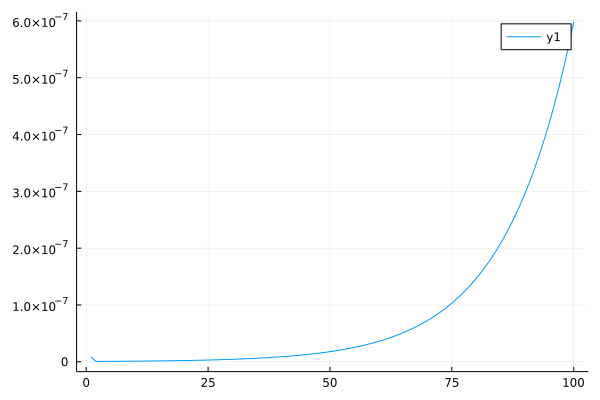

In [377]:
plot(l)

In [530]:
using Zygote

ρ, pback = Zygote.pullback(r⃗ -> get_electronic_density(r⃗, f), r⃗)

([0.26371813436629976, 0.4107304347207375, 0.4107304347207375, 0.26371813436629976, 0.26371813436629976], Zygote.var"#50#51"{typeof(∂(#552))}(∂(#552)))

In [531]:
ρ

5-element Vector{Float64}:
 0.26371813436629976
 0.4107304347207375
 0.4107304347207375
 0.26371813436629976
 0.26371813436629976

In [532]:
pback(ρ)[1]

LoadError: ArgumentError: broadcasting over dictionaries and `NamedTuple`s is reserved

In [512]:
Zygote.jacobian(x -> back(x)[1], ρ)

LoadError: Can't differentiate foreigncall expression

In [116]:
reshapr⃗[1,:]

3-element Vector{Float32}:
 0.0
 0.0
 0.0

In [115]:
evalu(x) = sum(Zygote.gradient(r⃗ -> get_electronic_density(r⃗, f),x)[1])
grad = evalu(r⃗[1,:])

LoadError: "expected a 2-array r⃗"

In [111]:
using Plots

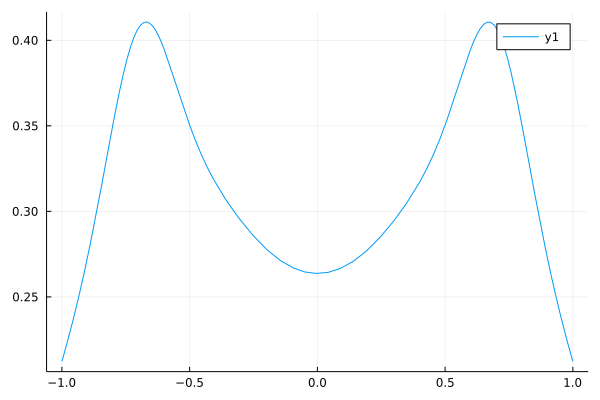

In [112]:
plot(x->get_electronic_density([Float32(0.0) Float32(0.0) Float32(x);] ,f)[1],-1.0,1.0)

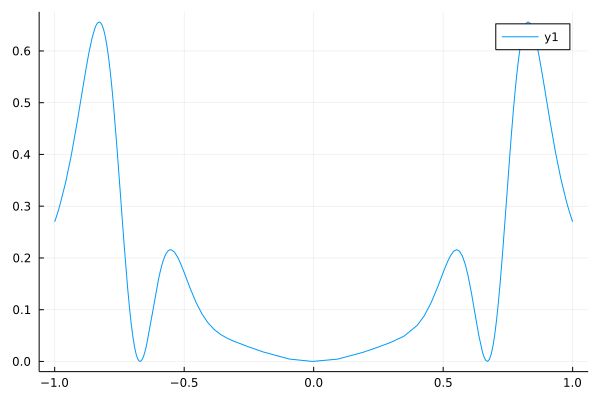

In [470]:
plot(x->gr([Float32(0.0) Float32(0.0) Float32(x);])^2,-1.0,1.0)

-32.23619130191664

In [73]:
jac_test(x, y, z) = [x^2+y-z 2*y*x 1/z]

jac_test (generic function with 1 method)

In [82]:
#Get J, then the next steps
J = Zygote.jacobian(x -> x^3+ x^2 + x^2', [1 2 1; 1 3 1; 1 2 6])[1]

9×9 Matrix{Int64}:
 13  16  12   8   2   1  12   2    1
  8  28  13   1  10   1   1  14    1
 12  26  63   1   2  13   1   2   17
 16   4   2  28  20  14  26   4    2
  2  20   2  10  47  15   2  30    2
  2   4  26  14  30  88   2   4   36
 12   2   1  13   2   1  63  26   17
  1  14   1   1  15   1  13  88   18
  1   2  17   1   2  18  17  36  138

In [107]:
#Seems to be working... for now....
#Need to fix the tullio incompatibility for it to work
using ForwardDiff

#Imagine X are gradients for three points
X = [1 2 1; 1 3 1; 1 2 6]

function test_f(X)
    J = ForwardDiff.jacobian(x -> x^3 + x^2 + x^2', X)
    @tullio detJ[i] := J[i,1]*(J[i,5]*J[i,9] - J[i,8]*J[i,6]) - J[i,2]*(J[i,4]*J[i,9]-J[i,7]*J[i,6]) + J[i,3]*(J[i,4]*J[i,8]-J[i,5]*J[i,7])
    sum(detJ.^2)
end

# Critical points: Those where the gradient does not change.
# If we have a function from k -> k (point to its gradient):
#     The determinant of its Jacobian is 0 when at a critical point
#     Therefore, if we square these and sum them, the loss function is minimized
#     When every point is a critical point.

test_f(X)

#@tullio detJ[i] := J[i,1]*(J[i,5]*J[i,9] - J[i,8]*J[i,6]) - J[i,2]*(J[i,4]*J[i,9]-J[i,7]*J[i,6]) + J[i,3]*(J[i,4]*J[i,8]-J[i,5]*J[i,7])

38781

In [103]:
det(reshape([13  16  12   8   2   1  12   2    1], 3, 3))

-32.0

In [109]:
Zygote.gradient(x -> test_f(x), X)[1]

3×3 Matrix{Float64}:
 -22572.0  100266.0   3378.0
  27912.0  -10566.0  38082.0
  24798.0   13056.0  33138.0